# Stock Planning Project with Demand Forecasting.

**Project Background:**\
Today is 31 July 2022, i was hired by a Q-commerce company to help them plan their stock management for August 2022 by forecasting demand for the upcoming month.
I was given a YTD shipment data of multiple product from multiple Hubs. From this data we will build our forecasting model.

**Project Goals:**\
This project ultimate goal is to provide the stock management team the most accurate prediction of demand for each product category in August 2022, enabling them to prepare their stock and minimize losses.

**Steps:**
1. Create virtual environment
2. Data Preprocessing
3. Building Baseline model
4. Evaluate Baseline model
5. Build more advance model (ARIMA) if baseline model is insufficient
6. Evaluate ARIMA model
7. Report

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

## **1. DATA PREPROCESSING**

In [239]:
df_OR = pd.read_csv(r'C:\Users\ammar\Documents\Data Analytics\Projects\Qcommerce Forecasting\Demand Planning Analysis (Data) - Final Weekly View.csv')
df_OR.head()

,Month,Category,Week,Hub,Shipped Qty
0,2022-01-01,A. Bahan & Bumbu Masak,W1,A,150.00
1,2022-01-01,A. Bahan & Bumbu Masak,W2,A,200.00
2,2022-01-01,A. Bahan & Bumbu Masak,W3,A,250.00
3,2022-01-01,A. Bahan & Bumbu Masak,W4,A,400.00
4,2022-01-01,B. Daging Beku,W1,A,150.00


In [240]:
df_OR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        1400 non-null   object
 1   Category     1400 non-null   object
 2   Week         1400 non-null   object
 3   Hub          1400 non-null   object
 4   Shipped Qty  1400 non-null   object
dtypes: object(5)
memory usage: 54.8+ KB


We will have to do some data cleaning by:
1. Convert Month column into datetime
2. Convert Week column into int
3. Create a complete date column by parsing Month and week with W1 + 0, W2 + 7, W3 + 14, W4 + 21, this will give us the start date of the week to use for time-series analysis\
(alternative: scratch step 3 and use converted week column for time series analysis, add extract month column to get actual month)

In [241]:
df = df_OR.copy()

In [242]:
df['Month'] = pd.to_datetime(df['Month']) #Convert to datetime
df['Week'] = df['Week'].str.extract('(\d+)').astype(int) #Convert to int

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        1400 non-null   datetime64[ns]
 1   Category     1400 non-null   object        
 2   Week         1400 non-null   int32         
 3   Hub          1400 non-null   object        
 4   Shipped Qty  1400 non-null   object        
dtypes: datetime64[ns](1), int32(1), object(3)
memory usage: 49.3+ KB


In [243]:
df.head(10)

,Month,Category,Week,Hub,Shipped Qty
0,2022-01-01,A. Bahan & Bumbu Masak,1,A,150.00
1,2022-01-01,A. Bahan & Bumbu Masak,2,A,200.00
2,2022-01-01,A. Bahan & Bumbu Masak,3,A,250.00
3,2022-01-01,A. Bahan & Bumbu Masak,4,A,400.00
4,2022-01-01,B. Daging Beku,1,A,150.00
5,2022-01-01,B. Daging Beku,2,A,200.00
6,2022-01-01,B. Daging Beku,3,A,250.00
7,2022-01-01,B. Daging Beku,4,A,400.00
8,2022-01-01,C. Kebutuhan Pokok,1,A,165.00
9,2022-01-01,C. Kebutuhan Pokok,2,A,220.00


In [244]:
df['Category'].value_counts()

Category
A. Bahan & Bumbu Masak       140
B. Daging Beku               140
C. Kebutuhan Pokok           140
D. Makanan Beku              140
E. Minuman                   140
F. Paket Masak               140
G. Protein (Ayam & Telur)    140
H. Sayur & Buah              140
I. Snack                     140
J. Susu & Olahan Susu        140
Name: count, dtype: int64

In [245]:
df['Hub'].value_counts()

Hub
A    280
B    280
C    280
D    280
E    280
Name: count, dtype: int64

As we see the data has multiple categories and hubs, for us to use statsforecast and utilsforecast we need to process this datset into acceptable format for the model which requires unique_id, ds (datestamp), and y as quantity.

For unique ID we will combine category and Hub, this way we'll be able to forecast per category in each hub so stock management is able to plan each hub.

As for the datestamp we will create a new column whith # of weeks.

For y we will convert Shipped Qty column into float. After that we create new data frame acceptable for forecast models.

In [246]:
df['unique_id'] = df['Hub'] + "-" + df['Category'] #Creates unique_id column

df['ds'] = (df['Month'].dt.month-1)*4 + df['Week'] #Creates datestamp columns that is week number 1-28

df['y'] = df['Shipped Qty'].astype(str).str.replace(',', '', regex=False).astype(float) #Creates y column as quantity shipped

df.head()

,Month,Category,Week,Hub,Shipped Qty,unique_id,ds,y
0,2022-01-01,A. Bahan & Bumbu Masak,1,A,150.00,A-A. Bahan & Bumbu Masak,1,150.0
1,2022-01-01,A. Bahan & Bumbu Masak,2,A,200.00,A-A. Bahan & Bumbu Masak,2,200.0
2,2022-01-01,A. Bahan & Bumbu Masak,3,A,250.00,A-A. Bahan & Bumbu Masak,3,250.0
3,2022-01-01,A. Bahan & Bumbu Masak,4,A,400.00,A-A. Bahan & Bumbu Masak,4,400.0
4,2022-01-01,B. Daging Beku,1,A,150.00,A-B. Daging Beku,1,150.0


In [247]:
df_model = df[['unique_id', 'ds', 'y']] # New Data Frame for modelling
df_model.head()

,unique_id,ds,y
0,A-A. Bahan & Bumbu Masak,1,150.0
1,A-A. Bahan & Bumbu Masak,2,200.0
2,A-A. Bahan & Bumbu Masak,3,250.0
3,A-A. Bahan & Bumbu Masak,4,400.0
4,A-B. Daging Beku,1,150.0


In [248]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   unique_id  1400 non-null   object 
 1   ds         1400 non-null   int32  
 2   y          1400 non-null   float64
dtypes: float64(1), int32(1), object(1)
memory usage: 27.5+ KB


In [299]:
df_modelovl = df[['Category', 'ds', 'y']].rename(columns={'Category':'unique_id'}).groupby(['unique_id', 'ds'])['y'].sum().reset_index()
df_modelovl

,unique_id,ds,y
0,A. Bahan & Bumbu Masak,1,916.0
1,A. Bahan & Bumbu Masak,2,1220.0
2,A. Bahan & Bumbu Masak,3,1526.0
3,A. Bahan & Bumbu Masak,4,2440.0
4,A. Bahan & Bumbu Masak,5,2993.0
...,...,...,...
275,J. Susu & Olahan Susu,24,21885.0
276,J. Susu & Olahan Susu,25,8946.0
277,J. Susu & Olahan Susu,26,11929.0
278,J. Susu & Olahan Susu,27,14910.0


In [297]:
ids = df['Category'].unique()
ids

array(['A. Bahan & Bumbu Masak', 'B. Daging Beku', 'C. Kebutuhan Pokok',
       'D. Makanan Beku', 'E. Minuman', 'F. Paket Masak',
       'G. Protein (Ayam & Telur)', 'H. Sayur & Buah', 'I. Snack',
       'J. Susu & Olahan Susu'], dtype=object)

Before we start any modelling, we will do overall Exploratory Data Analysis to get the bird-eye view of the overall performance of the company

## **2. EDA**

In [250]:
df['y'].sum()

2152036.0

In [251]:
total_hub = df.groupby(['Hub'])['y'].sum()
total_hub

Hub
A    354100.0
B    363896.0
C    473641.0
D    471207.0
E    489192.0
Name: y, dtype: float64

C:\Users\ammar\AppData\Local\Temp\ipykernel_7480\3206982988.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


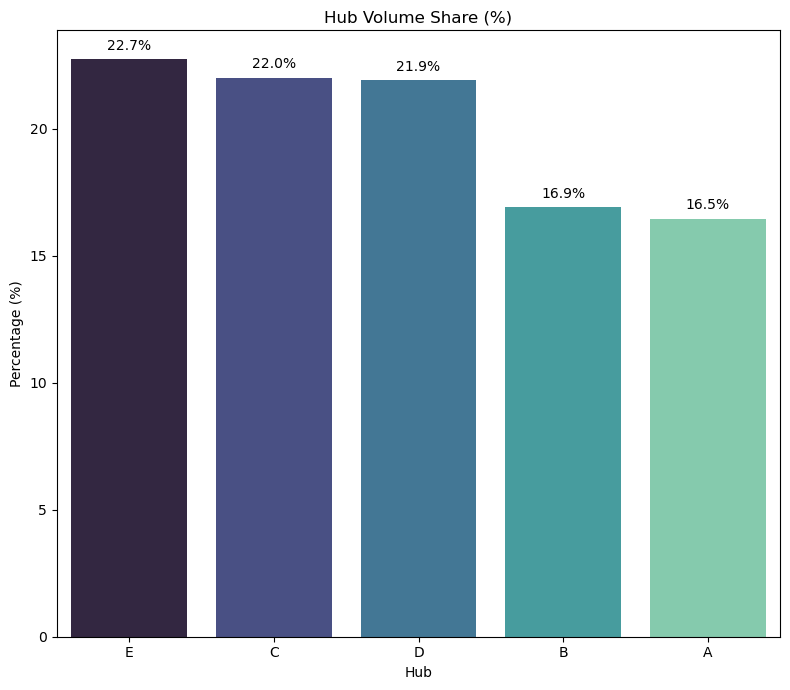

In [252]:
import seaborn as sns

percent_share = (total_hub / total_hub.sum()) * 100
percent_share = percent_share.sort_values(ascending=False)

plot_df = percent_share.sort_values(ascending=False).reset_index()
plot_df.columns = ["Hub", "Percent"]

# Plot
plt.figure(figsize=(8, 7))
sns.barplot(
    data=plot_df,
    x="Hub",
    y="Percent",
    palette="mako"   # change to any seaborn palette!
)

plt.title("Hub Volume Share (%)")
plt.xlabel("Hub")
plt.ylabel("Percentage (%)")

# Add % labels on bars
for i, v in enumerate(plot_df["Percent"]):
    plt.text(i, v + 0.25, f"{v:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [253]:
total_prod = df.groupby('Category')['y'].sum().reset_index()
total_prod['%'] = (total_prod['y'] / total_prod['y'].sum()).map(lambda x: f"{x:.2f}")
total_prod

,Category,y,%
0,A. Bahan & Bumbu Masak,249131.0,0.12
1,B. Daging Beku,145590.0,0.07
2,C. Kebutuhan Pokok,36279.0,0.02
3,D. Makanan Beku,115628.0,0.05
4,E. Minuman,116601.0,0.05
5,F. Paket Masak,230262.0,0.11
6,G. Protein (Ayam & Telur),85245.0,0.04
7,H. Sayur & Buah,703770.0,0.33
8,I. Snack,157581.0,0.07
9,J. Susu & Olahan Susu,311949.0,0.14


In [254]:
total_prod.to_csv(r'C:\Users\ammar\Documents\Data Analytics\Projects\Qcommerce Forecasting\total_prod.csv')

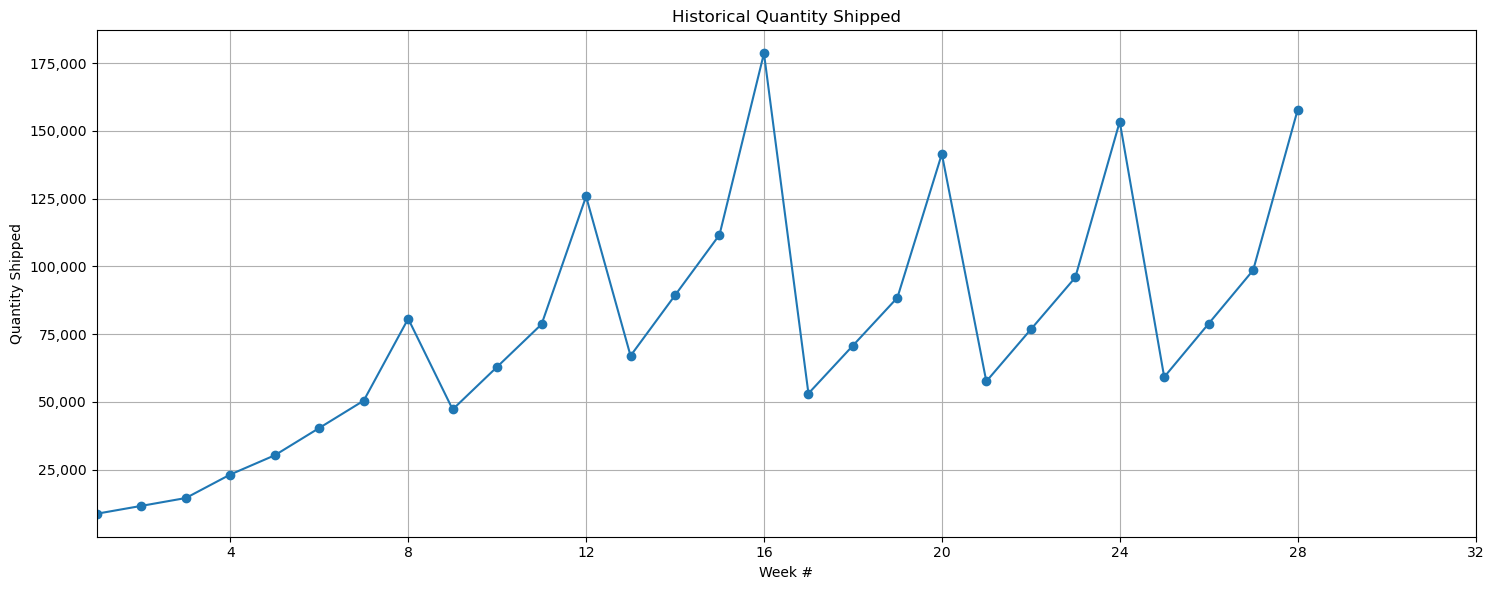

In [255]:
#Overall shipped products
df_ovrl = df.groupby(['ds'])['y'].sum().reset_index()

plt.figure(figsize=(15,6))

plt.plot(df_ovrl['ds'], df_ovrl['y'], marker='o')

plt.title("Historical Quantity Shipped")
plt.xlabel("Week #")
plt.xticks(ticks=range(0, len(df_ovrl['ds'].unique()) + 5, 4))
plt.ylabel("Quantity Shipped")
plt.grid(True)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}"))
plt.xlim(df_ovrl['ds'].min(), df_ovrl['ds'].max() + 4)


plt.show()

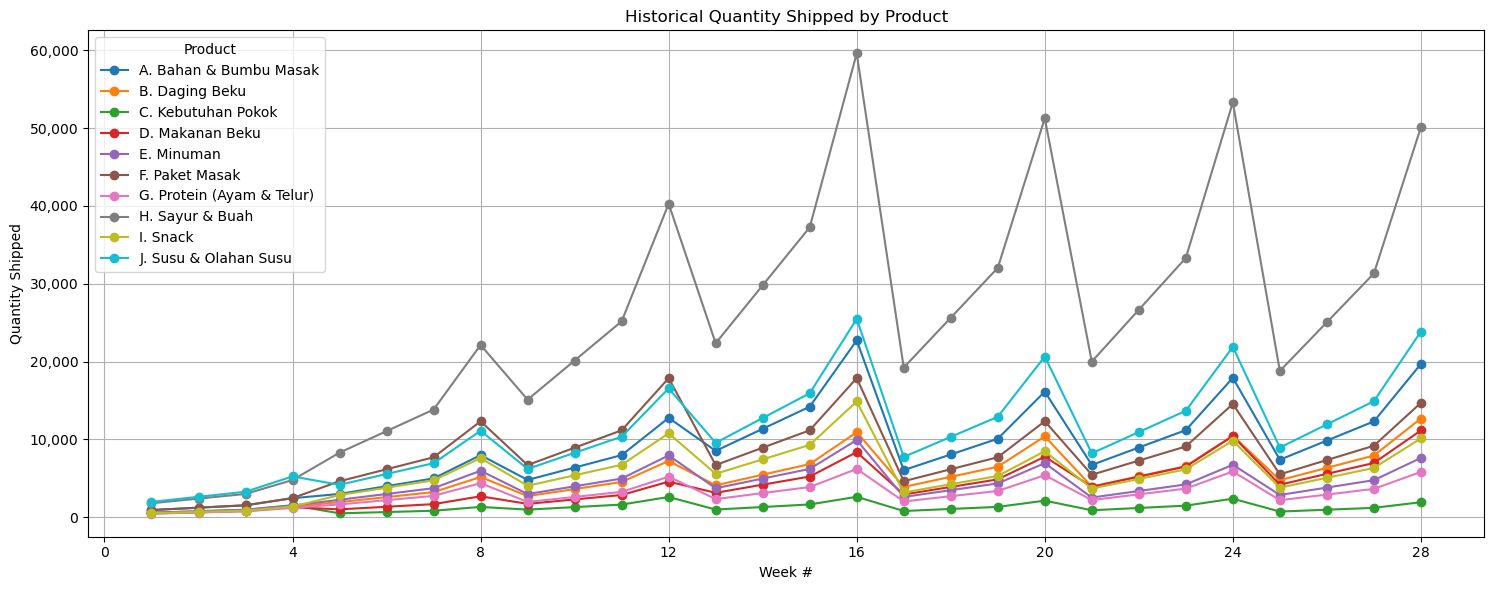

In [256]:
#Overall shipped products
df_cat = df.groupby(['Category', 'ds'])['y'].sum().reset_index()

plt.figure(figsize=(15,6))

for cat in df_cat['Category'].unique():
    temp1 = df_cat[df_cat['Category'] == cat]
    plt.plot(temp1['ds'], temp1['y'], label = cat, marker='o')

plt.title("Historical Quantity Shipped by Product")
plt.xlabel("Week #")
plt.xticks(ticks=range(0, len(df_cat['ds'].unique())+1, 4))
plt.ylabel("Quantity Shipped")
plt.legend(title="Product")
plt.grid(True)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}"))

plt.show()

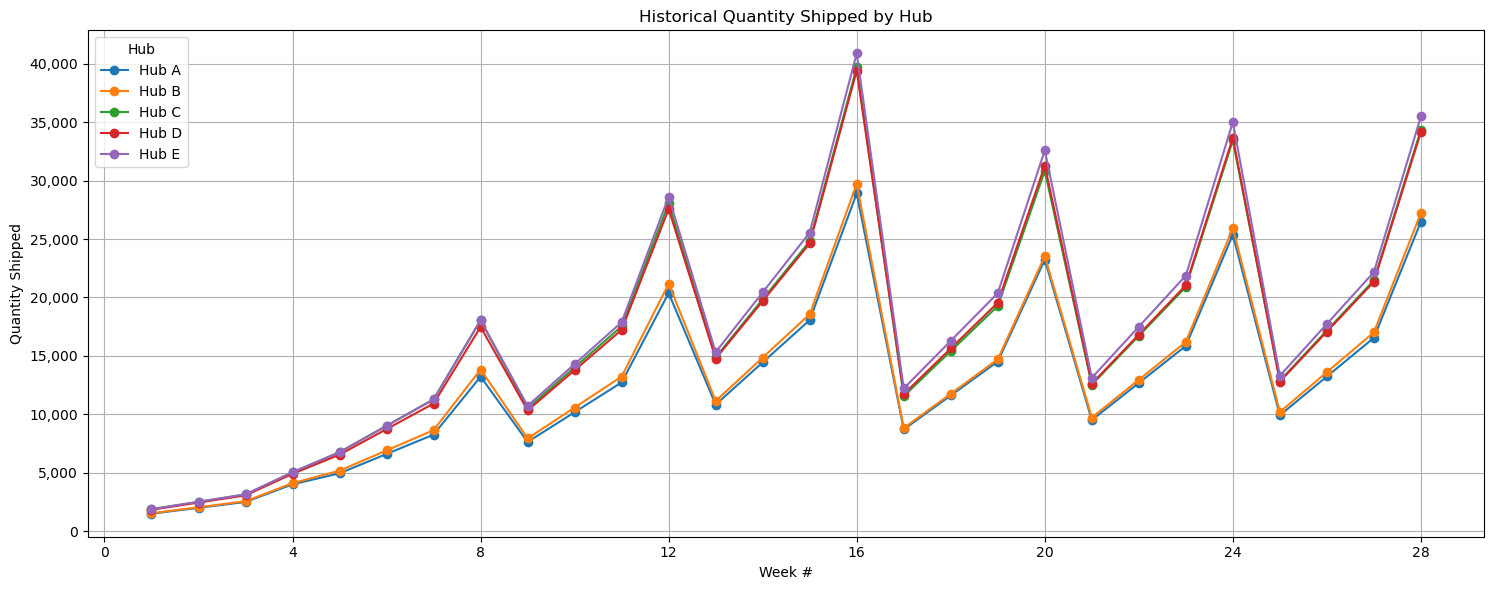

In [257]:
# Overall shipped volume each Hubs
df_hubp = df.groupby(['Hub', 'ds'])['y'].sum().reset_index()

plt.figure(figsize=(15, 6))

for hub in df_hubp['Hub'].unique():
    temp = df_hubp[df_hubp['Hub'] == hub]
    plt.plot(temp['ds'], temp['y'], label=f"Hub {hub}", marker='o')

plt.title("Historical Quantity Shipped by Hub")
plt.xlabel("Week #")
plt.xticks(ticks=range(0, len(df_cat['ds'].unique())+1, 4))
plt.ylabel("Quantity Shipped")
plt.legend(title="Hub")
plt.grid(True)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}"))

plt.show()

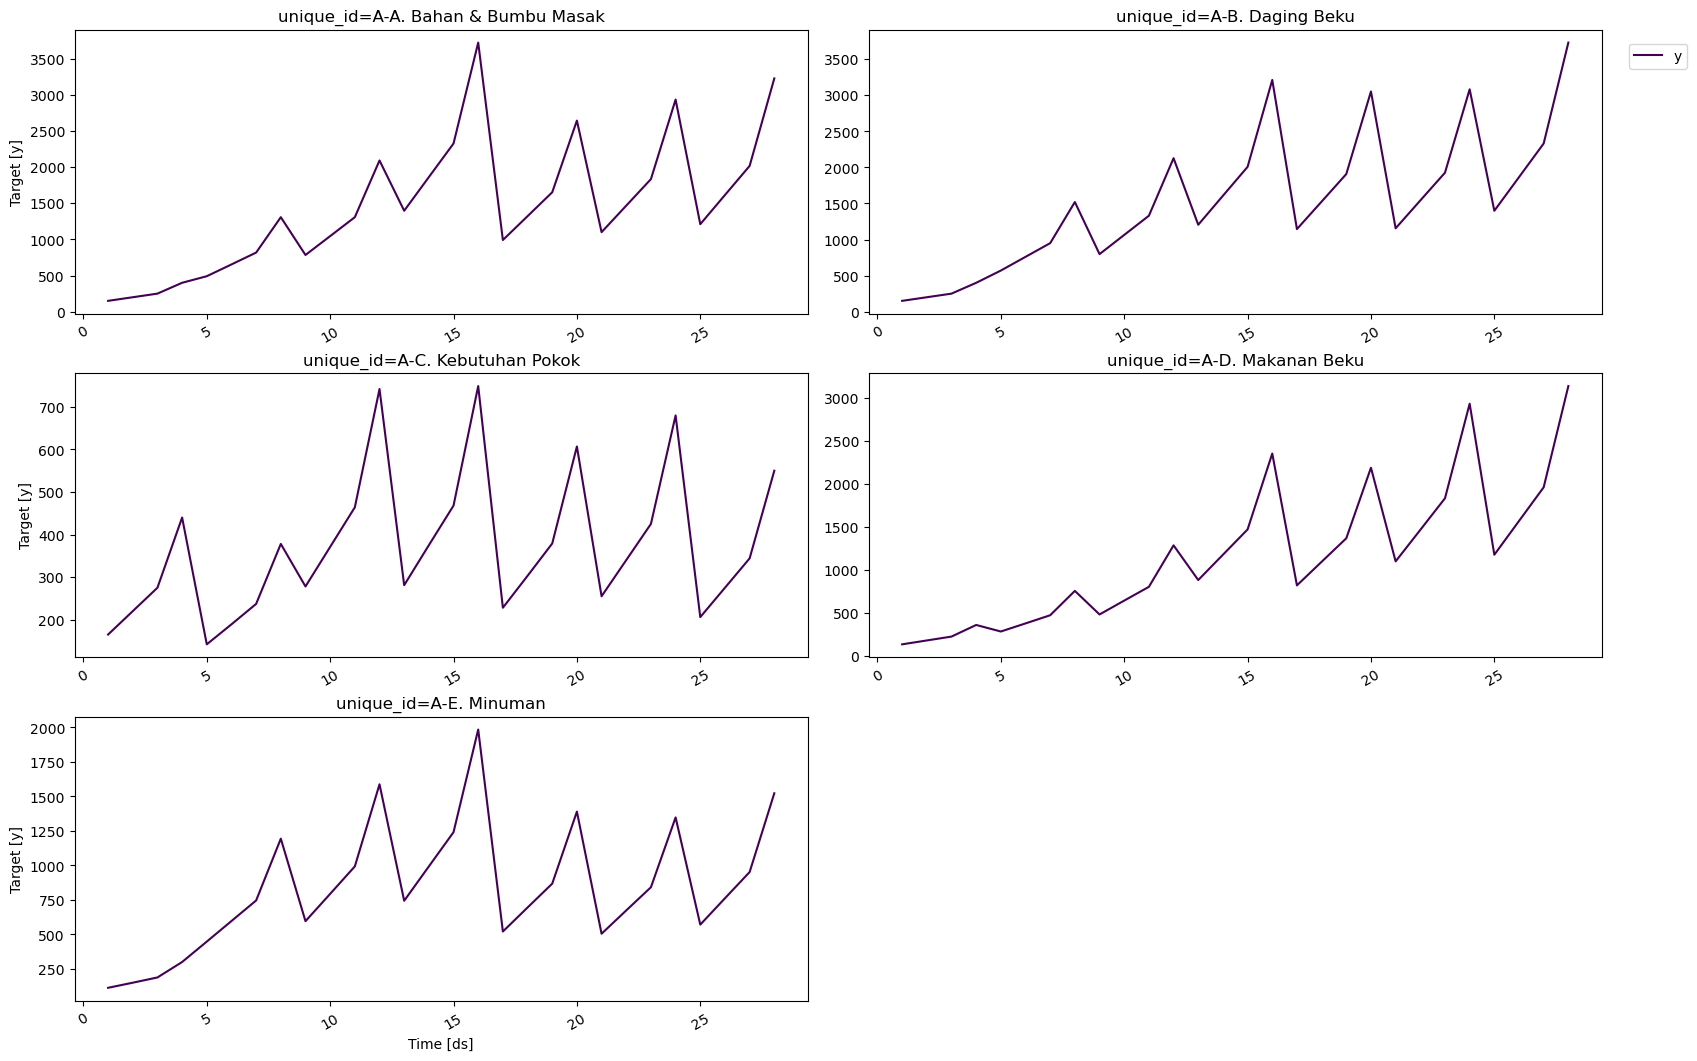

In [258]:
df_model_A = df_model[df_model['unique_id'].str.startswith('A-')]

hub_A_id = df_model_A['unique_id'].unique().tolist()

hub_A_1 = hub_A_id[:5]
hub_A_2 = hub_A_id[5:]

plot_series(df=df_model_A, ids=hub_A_1, palette='viridis')

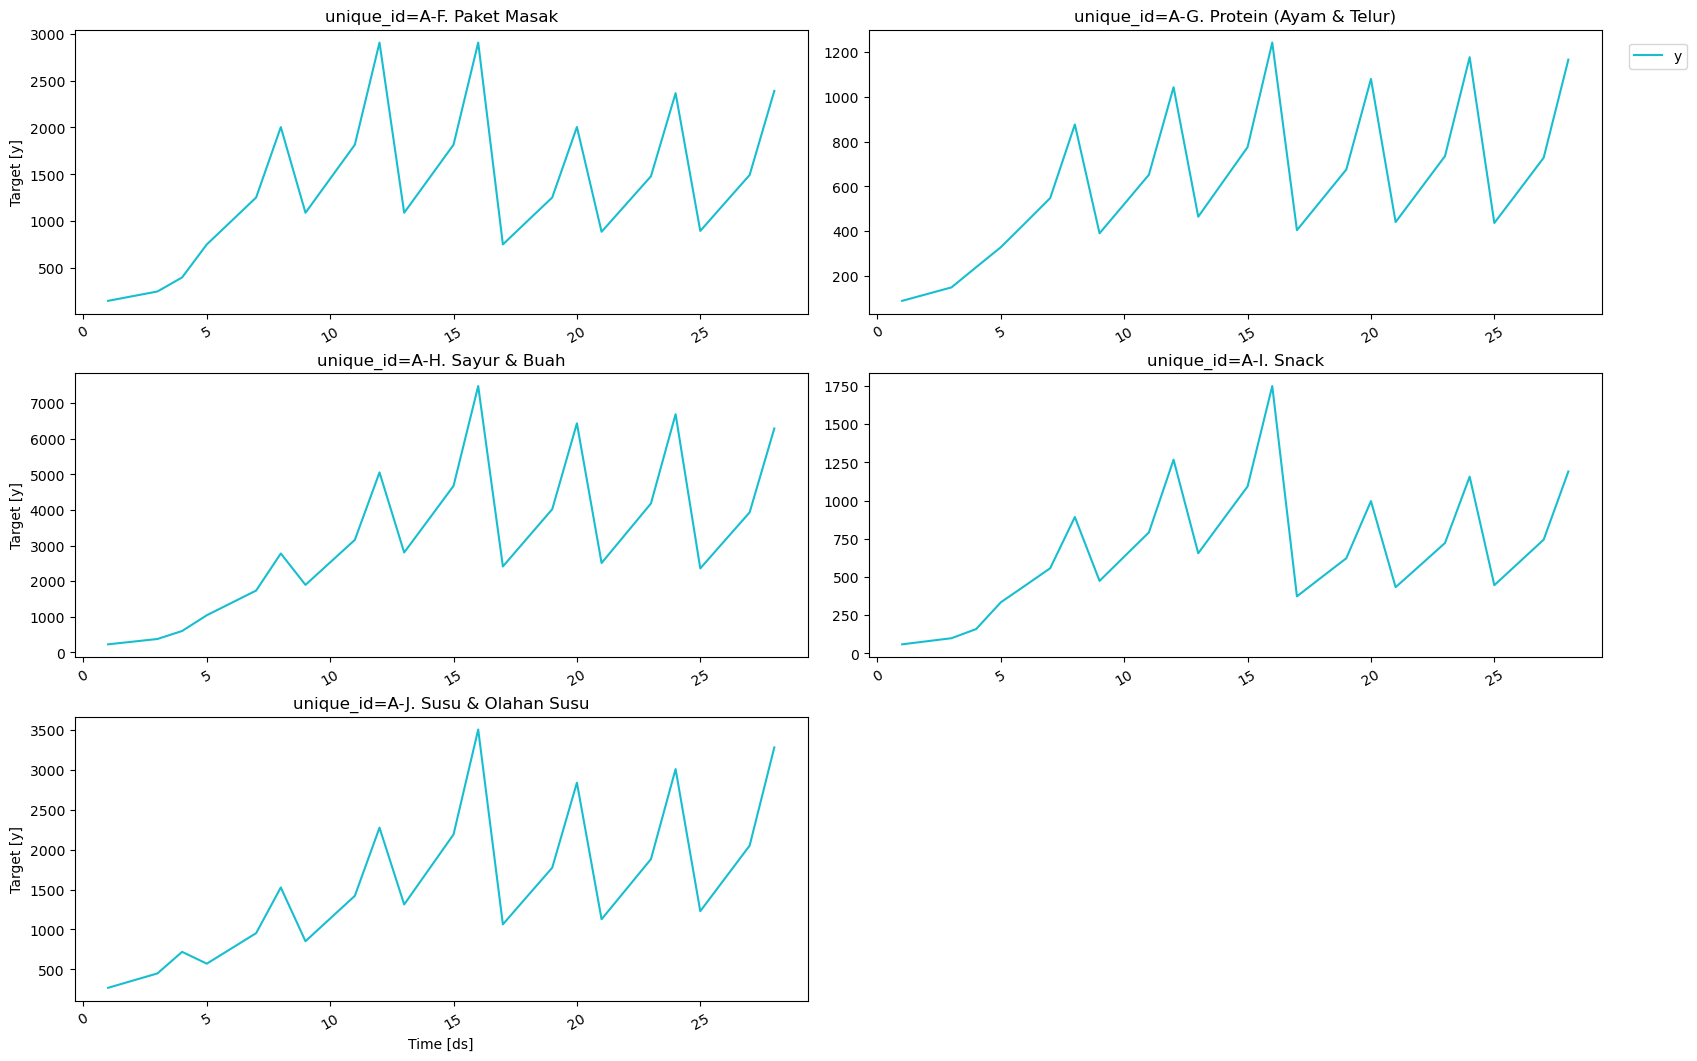

In [259]:
plot_series(df=df_model_A, ids=hub_A_2)

In [260]:
df_model_A.head()

,unique_id,ds,y
0,A-A. Bahan & Bumbu Masak,1,150.0
1,A-A. Bahan & Bumbu Masak,2,200.0
2,A-A. Bahan & Bumbu Masak,3,250.0
3,A-A. Bahan & Bumbu Masak,4,400.0
4,A-B. Daging Beku,1,150.0


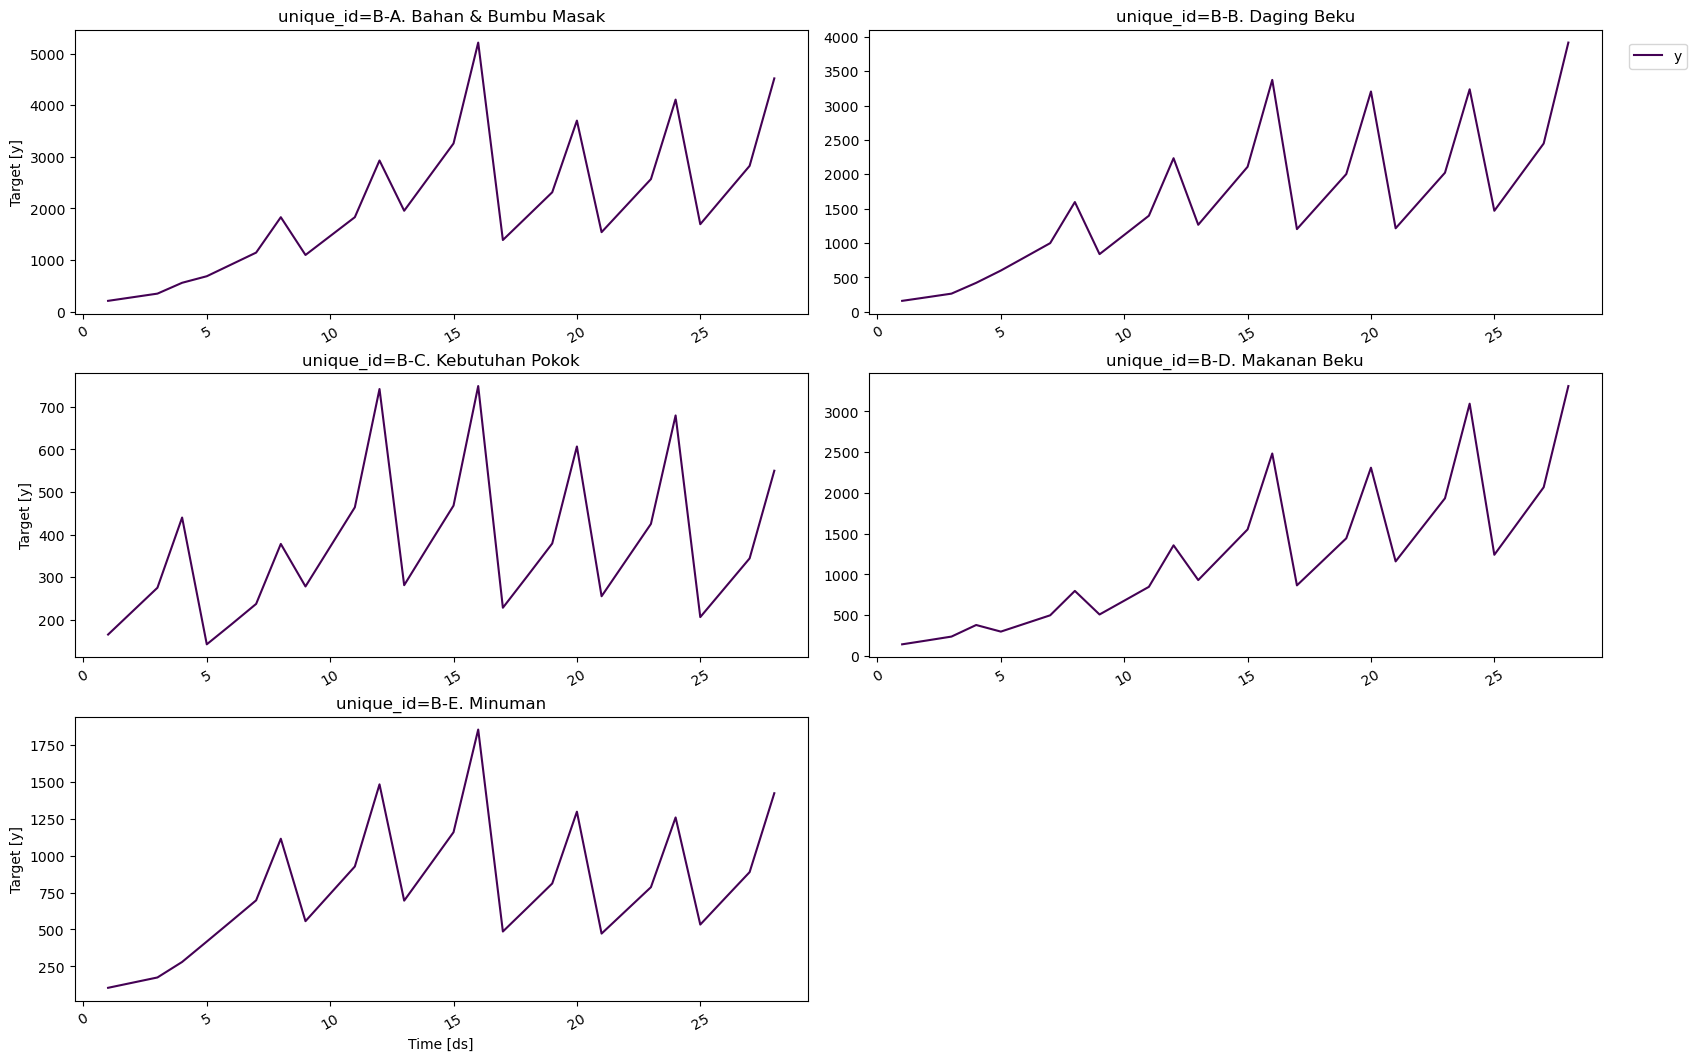

In [261]:
df_model_B = df_model[df_model['unique_id'].str.startswith('B-')]

hub_B_id = df_model_B['unique_id'].unique().tolist()

hub_B_1 = hub_B_id[:5]
hub_B_2 = hub_B_id[5:]

plot_series(df=df_model_B, ids=hub_B_1, palette='viridis')

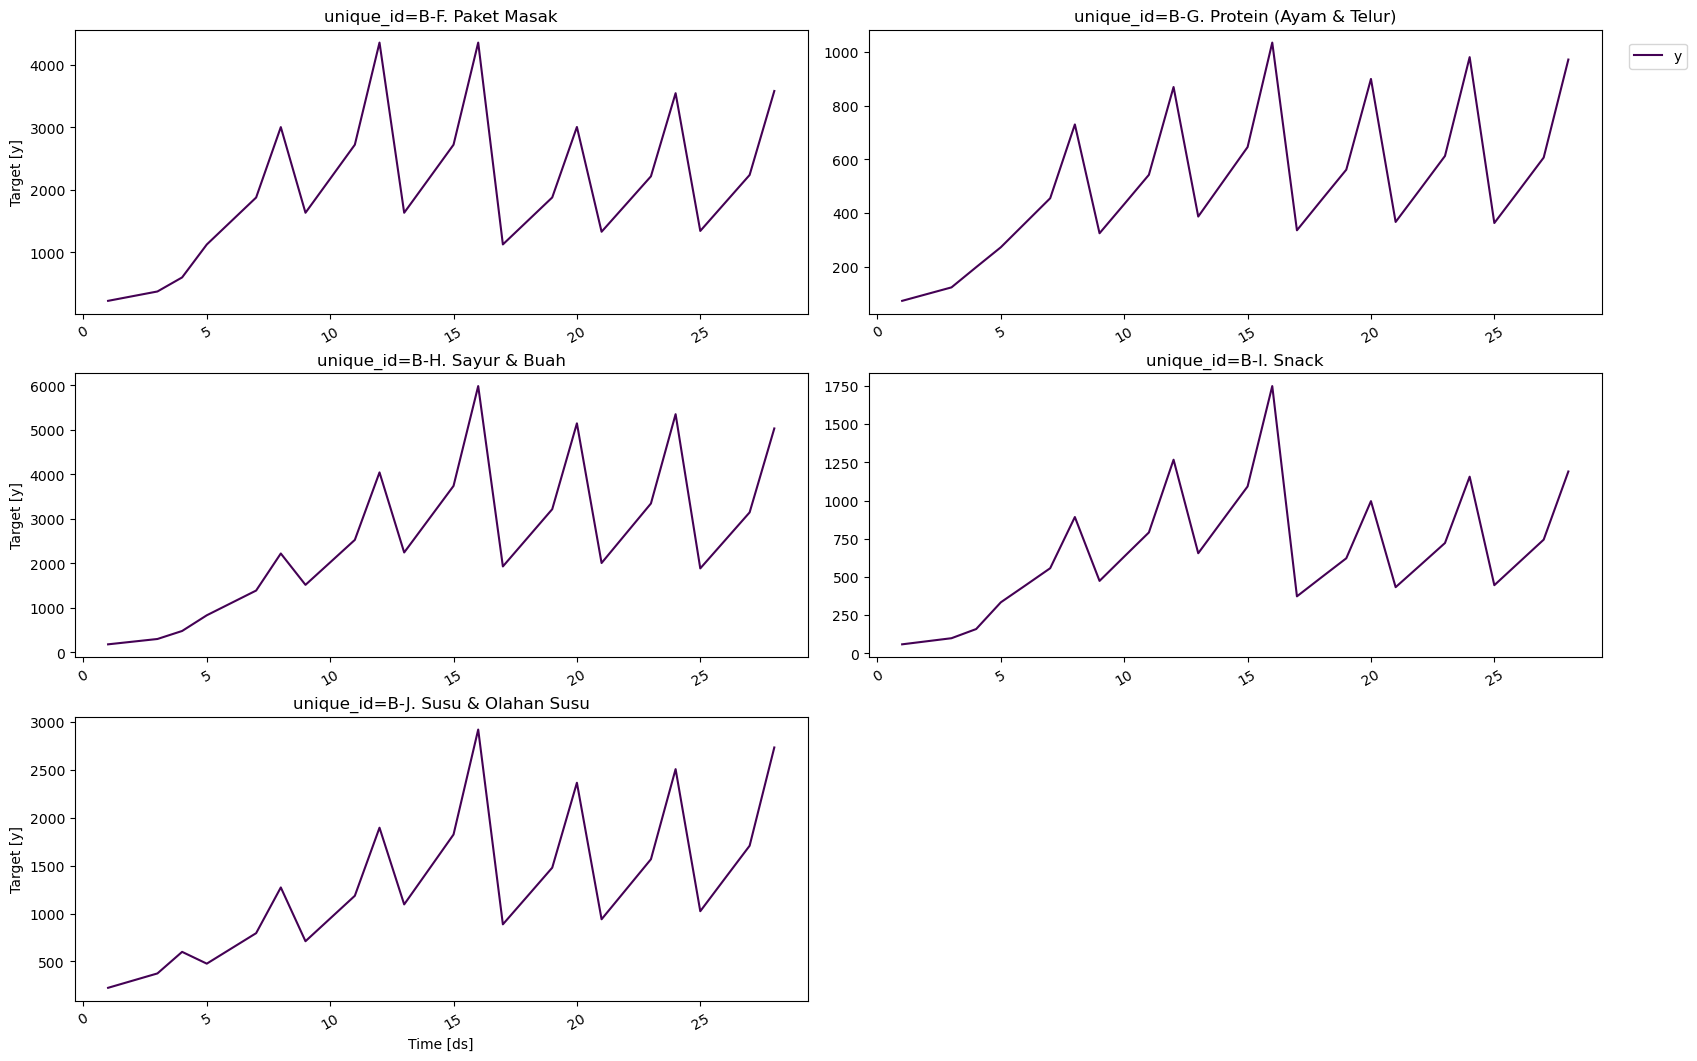

In [262]:
plot_series(df=df_model_B, ids=hub_B_2, palette='viridis')

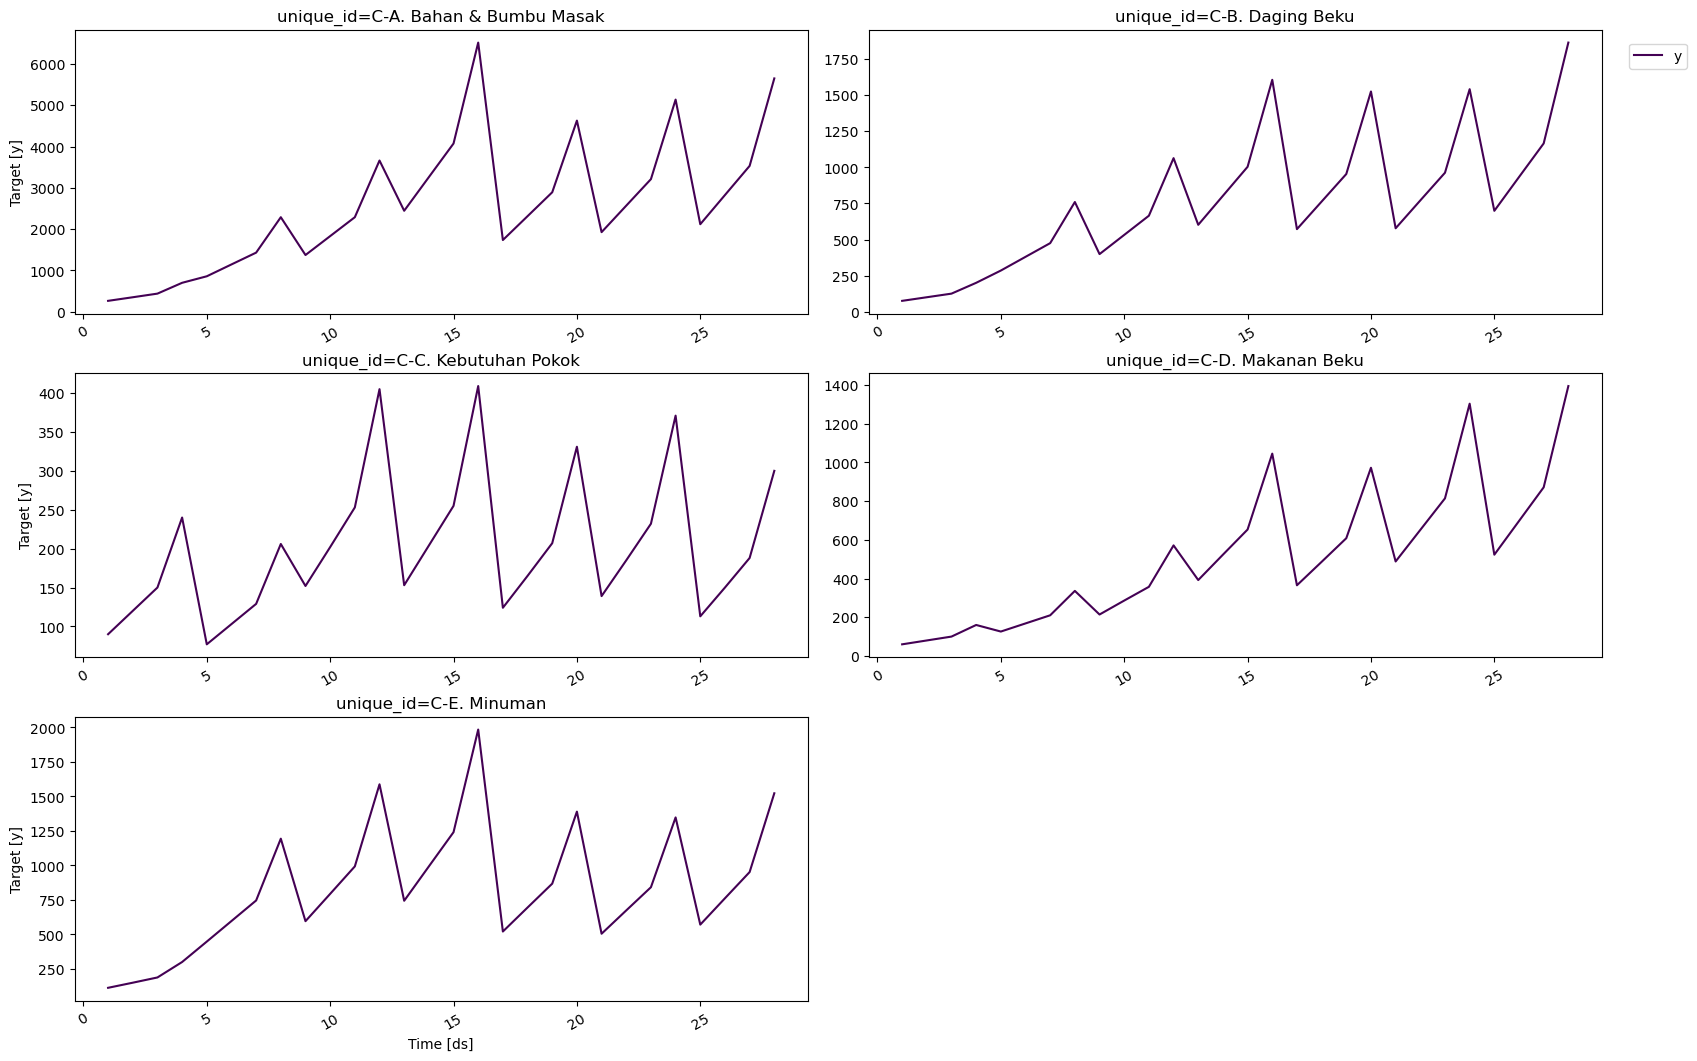

In [263]:
df_model_C = df_model[df_model['unique_id'].str.startswith('C-')]

hub_C_id = df_model_C['unique_id'].unique().tolist()

hub_C_1 = hub_C_id[:5]
hub_C_2 = hub_C_id[5:]

plot_series(df=df_model_C, ids=hub_C_1, palette='viridis')

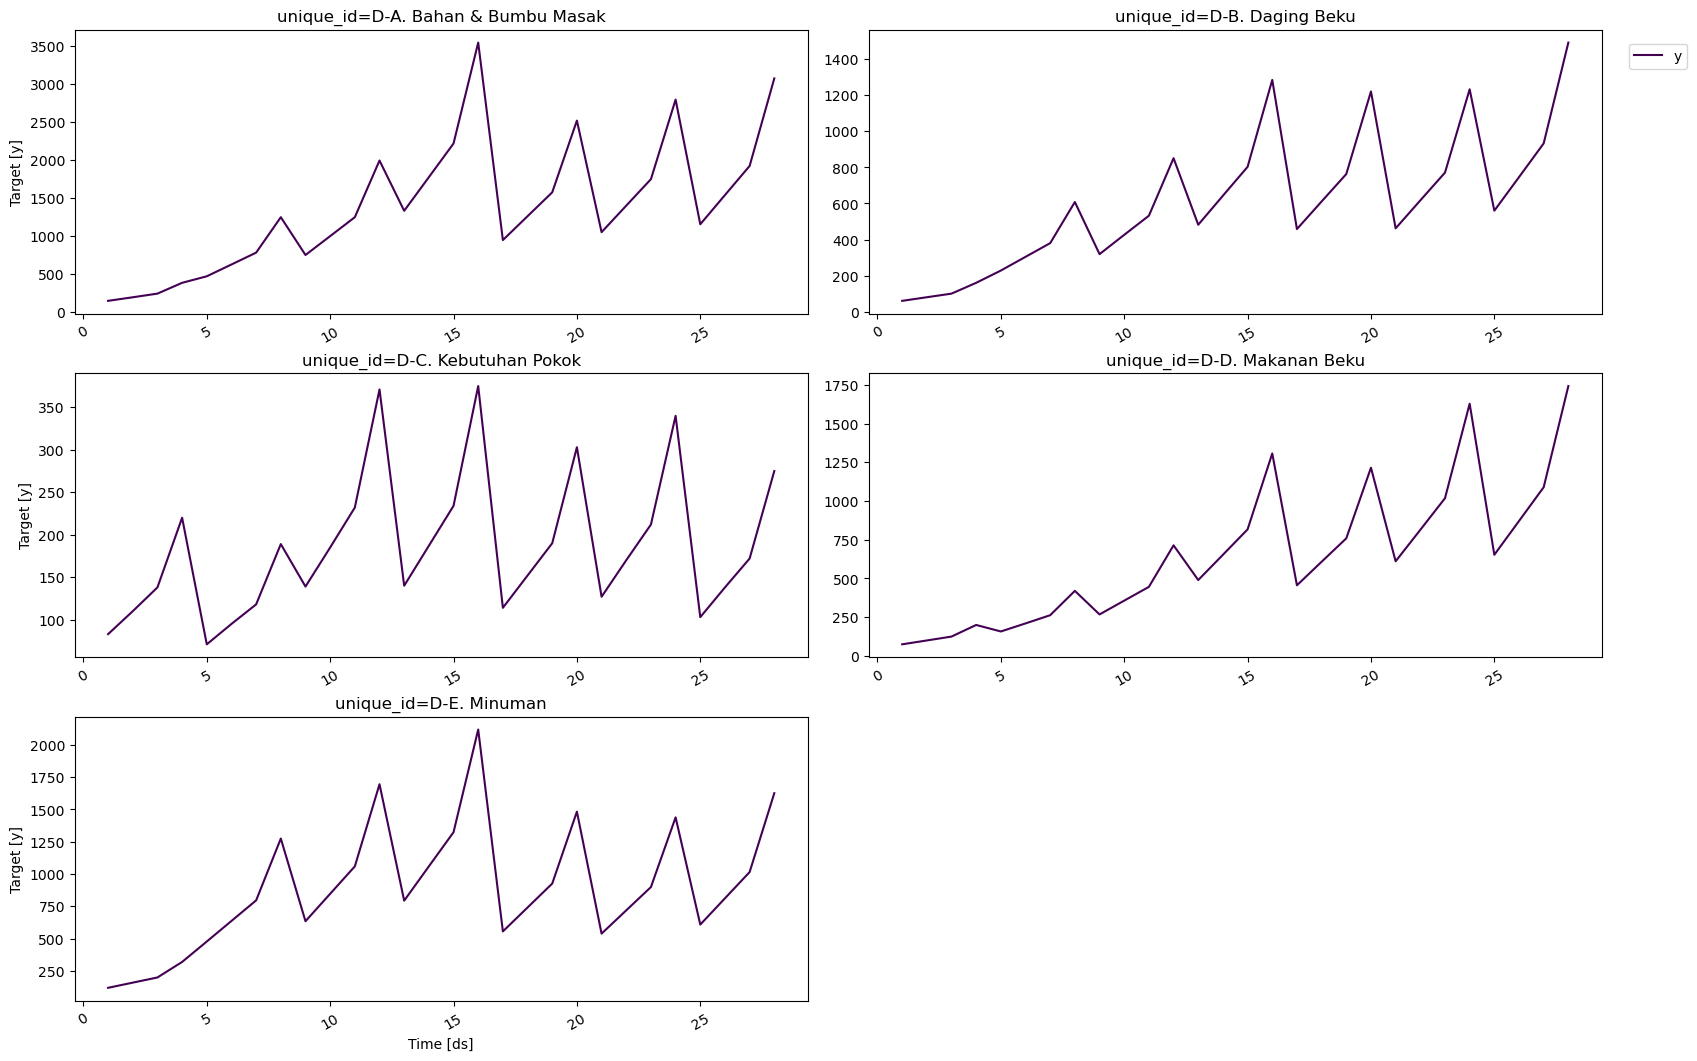

In [264]:
df_model_D = df_model[df_model['unique_id'].str.startswith('D-')]

hub_D_id = df_model_D['unique_id'].unique().tolist()

hub_D_1 = hub_D_id[:5]
hub_D_2 = hub_D_id[5:]

plot_series(df=df_model_D, ids=hub_D_1, palette='viridis')

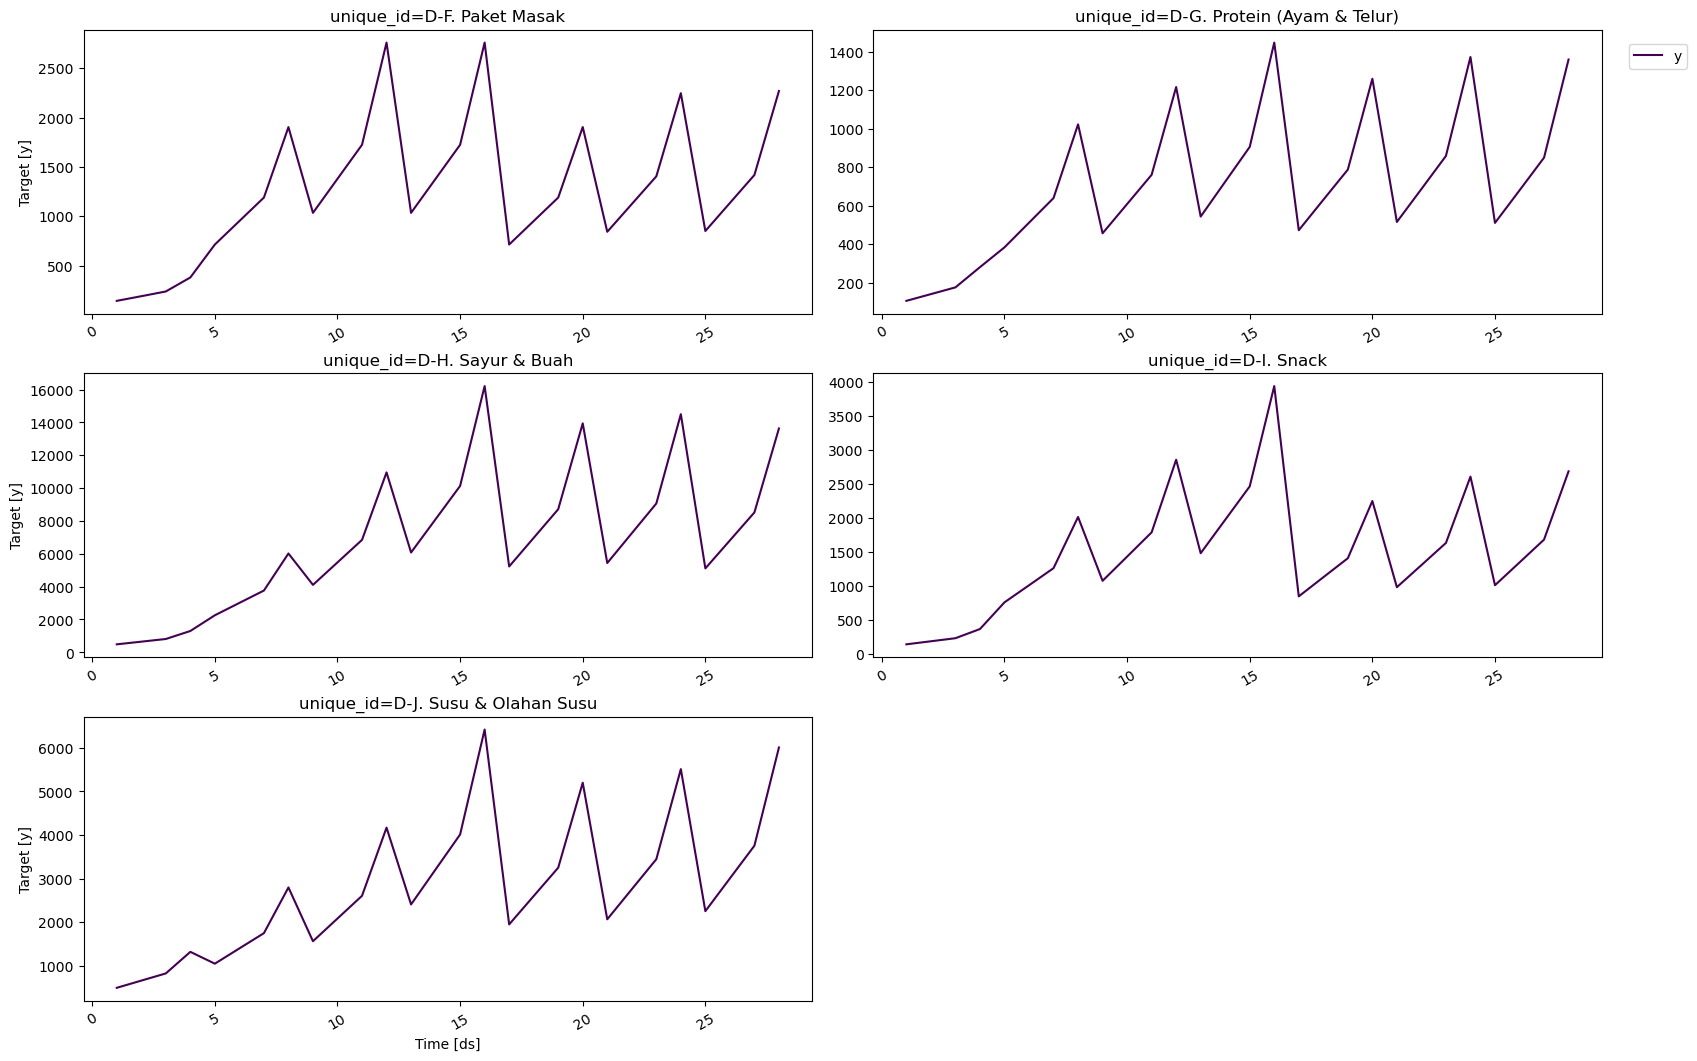

In [265]:
plot_series(df=df_model_D, ids=hub_D_2, palette='viridis')

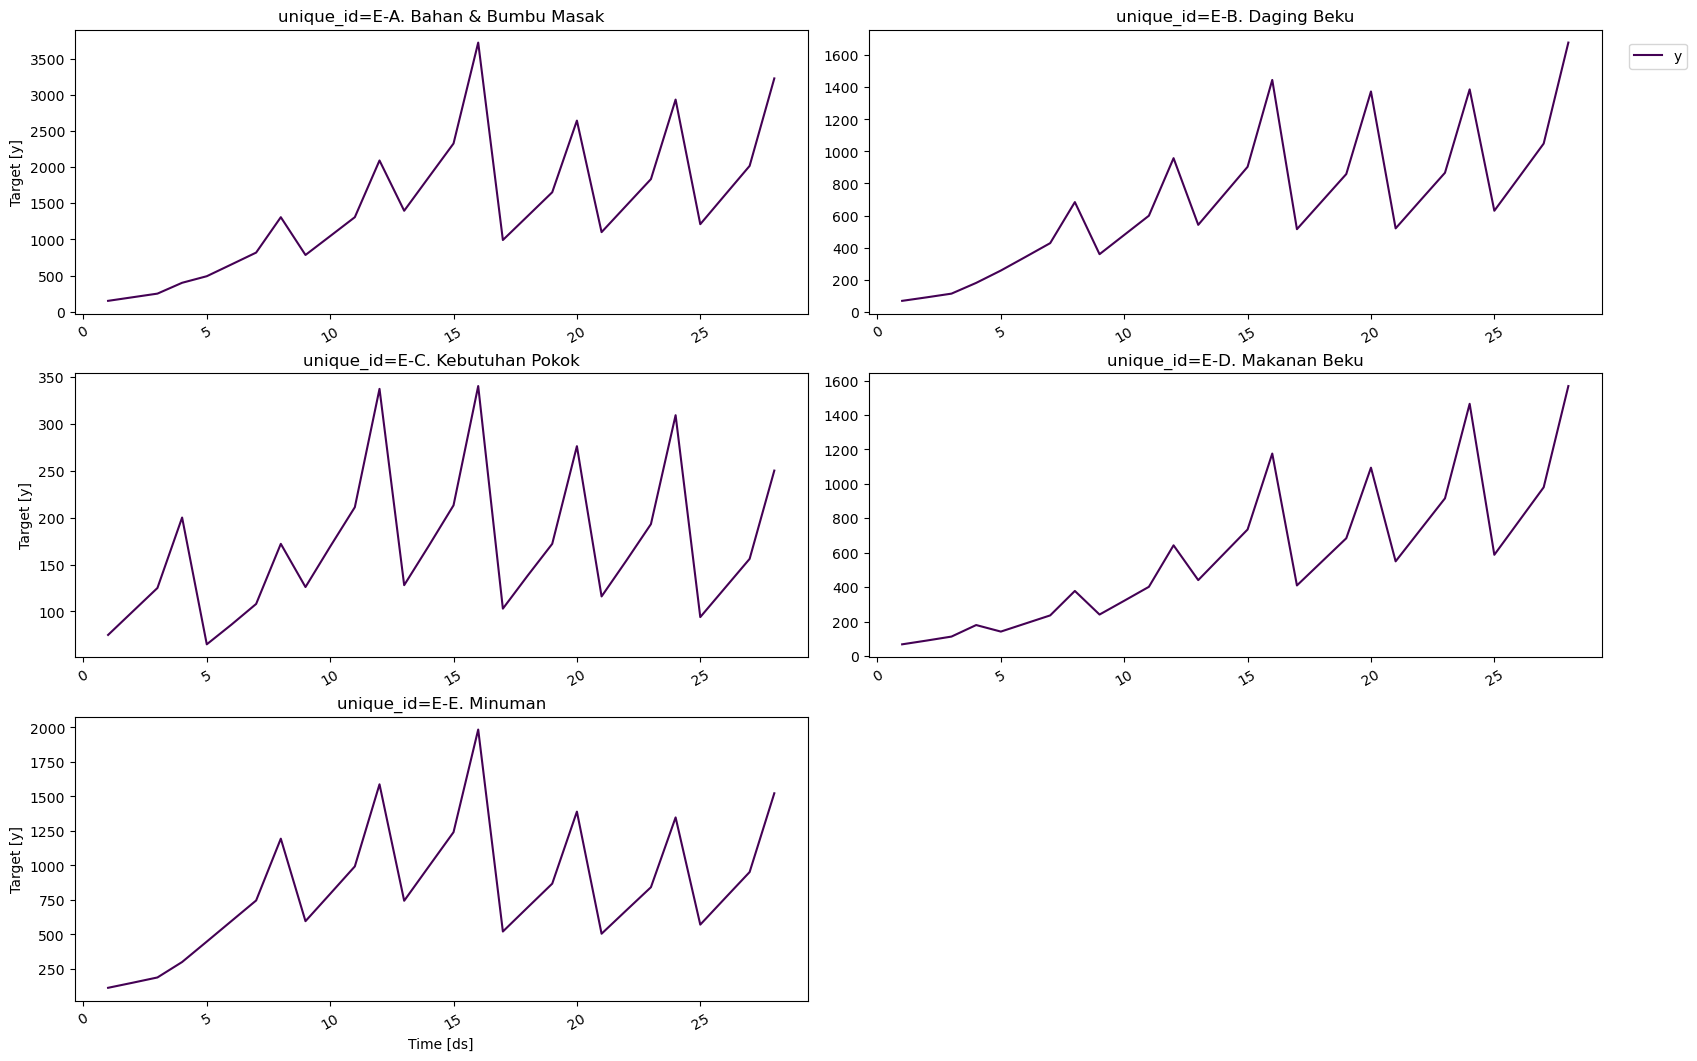

In [266]:
df_model_E = df_model[df_model['unique_id'].str.startswith('E-')]

hub_E_id = df_model_E['unique_id'].unique().tolist()

hub_E_1 = hub_E_id[:5]
hub_E_2 = hub_E_id[5:]

plot_series(df=df_model_E, ids=hub_E_1, palette='viridis')

In [267]:
unique_ids = df_model['unique_id'].unique()
unique_ids

array(['A-A. Bahan & Bumbu Masak', 'A-B. Daging Beku',
       'A-C. Kebutuhan Pokok', 'A-D. Makanan Beku', 'A-E. Minuman',
       'A-F. Paket Masak', 'A-G. Protein (Ayam & Telur)',
       'A-H. Sayur & Buah', 'A-I. Snack', 'A-J. Susu & Olahan Susu',
       'B-A. Bahan & Bumbu Masak', 'B-B. Daging Beku',
       'B-C. Kebutuhan Pokok', 'B-D. Makanan Beku', 'B-E. Minuman',
       'B-F. Paket Masak', 'B-G. Protein (Ayam & Telur)',
       'B-H. Sayur & Buah', 'B-I. Snack', 'B-J. Susu & Olahan Susu',
       'C-A. Bahan & Bumbu Masak', 'C-B. Daging Beku',
       'C-C. Kebutuhan Pokok', 'C-D. Makanan Beku', 'C-E. Minuman',
       'C-F. Paket Masak', 'C-G. Protein (Ayam & Telur)',
       'C-H. Sayur & Buah', 'C-I. Snack', 'C-J. Susu & Olahan Susu',
       'D-A. Bahan & Bumbu Masak', 'D-B. Daging Beku',
       'D-C. Kebutuhan Pokok', 'D-D. Makanan Beku', 'D-E. Minuman',
       'D-F. Paket Masak', 'D-G. Protein (Ayam & Telur)',
       'D-H. Sayur & Buah', 'D-I. Snack', 'D-J. Susu & Olahan Susu',


## **3. Baseline Models Forecast**

In [268]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

### Overall Product Forecast

In [345]:
horizon = 4

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=4),
    SeasonalNaive(season_length=4)
]

sf = StatsForecast(models=models, freq=1)
sf.fit(df=df_modelovl)
predsovl = sf.predict(h=horizon)

predsovl.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,A. Bahan & Bumbu Masak,29,19698.0,8897.535714,12311.50,7386.0
1,A. Bahan & Bumbu Masak,30,19698.0,8897.535714,12311.50,9851.0
2,A. Bahan & Bumbu Masak,31,19698.0,8897.535714,12311.50,12311.0
3,A. Bahan & Bumbu Masak,32,19698.0,8897.535714,12311.50,19698.0
4,B. Daging Beku,29,12684.0,5199.642857,7927.75,4757.0


In [341]:
ids1 = ids[:4]
ids2 = ids[4:]

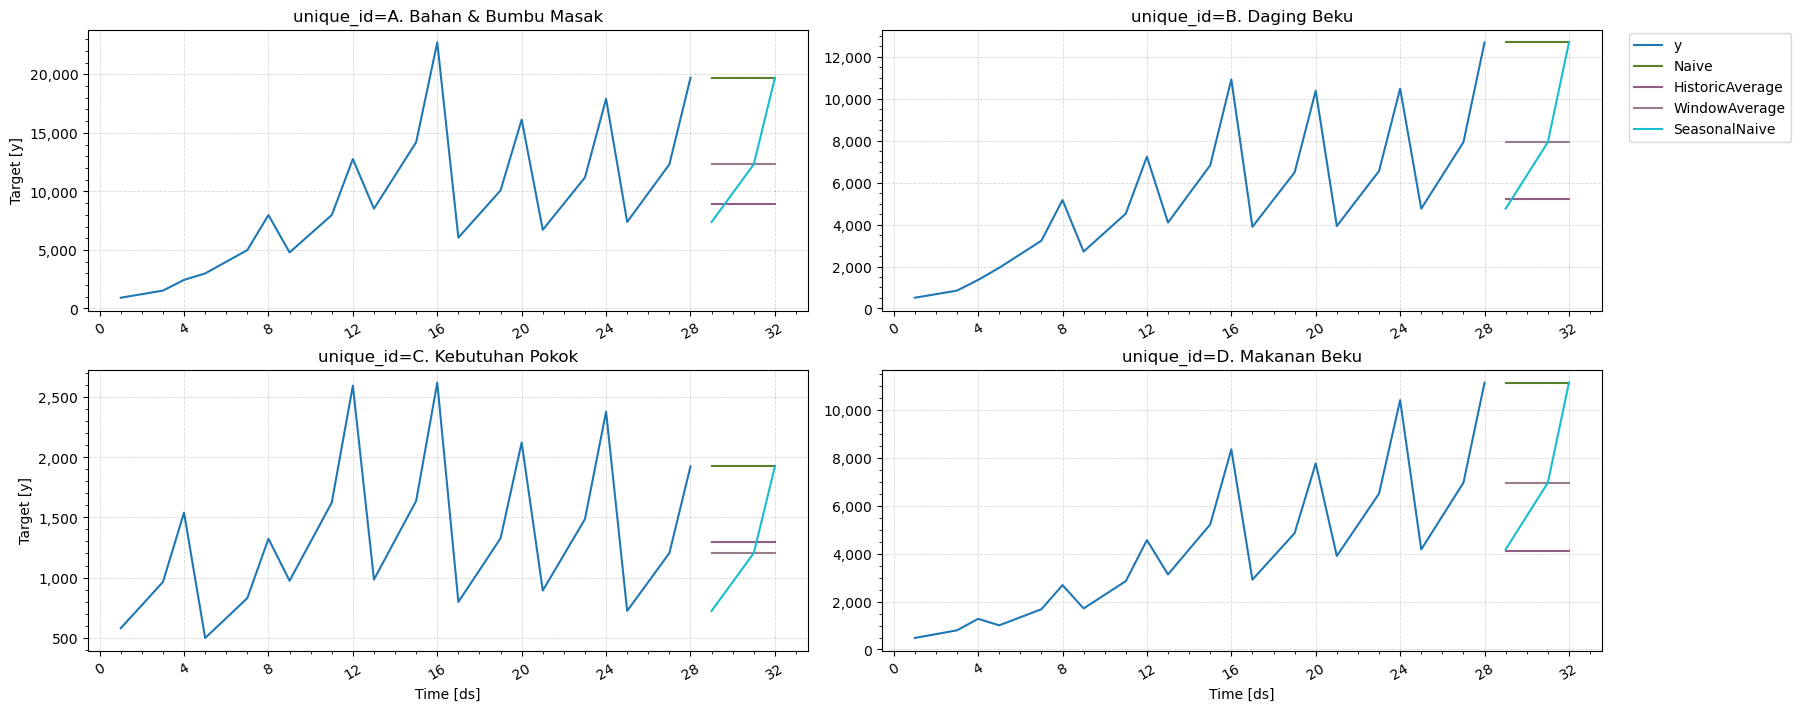

In [342]:
fig = plot_series(df=df_modelovl, forecasts_df=predsovl, ids=ids1)

for ax in fig.axes:
    ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.5)
    ax.minorticks_on()
    ax.set_xticks(ticks=range(0,33,4))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}"))

fig

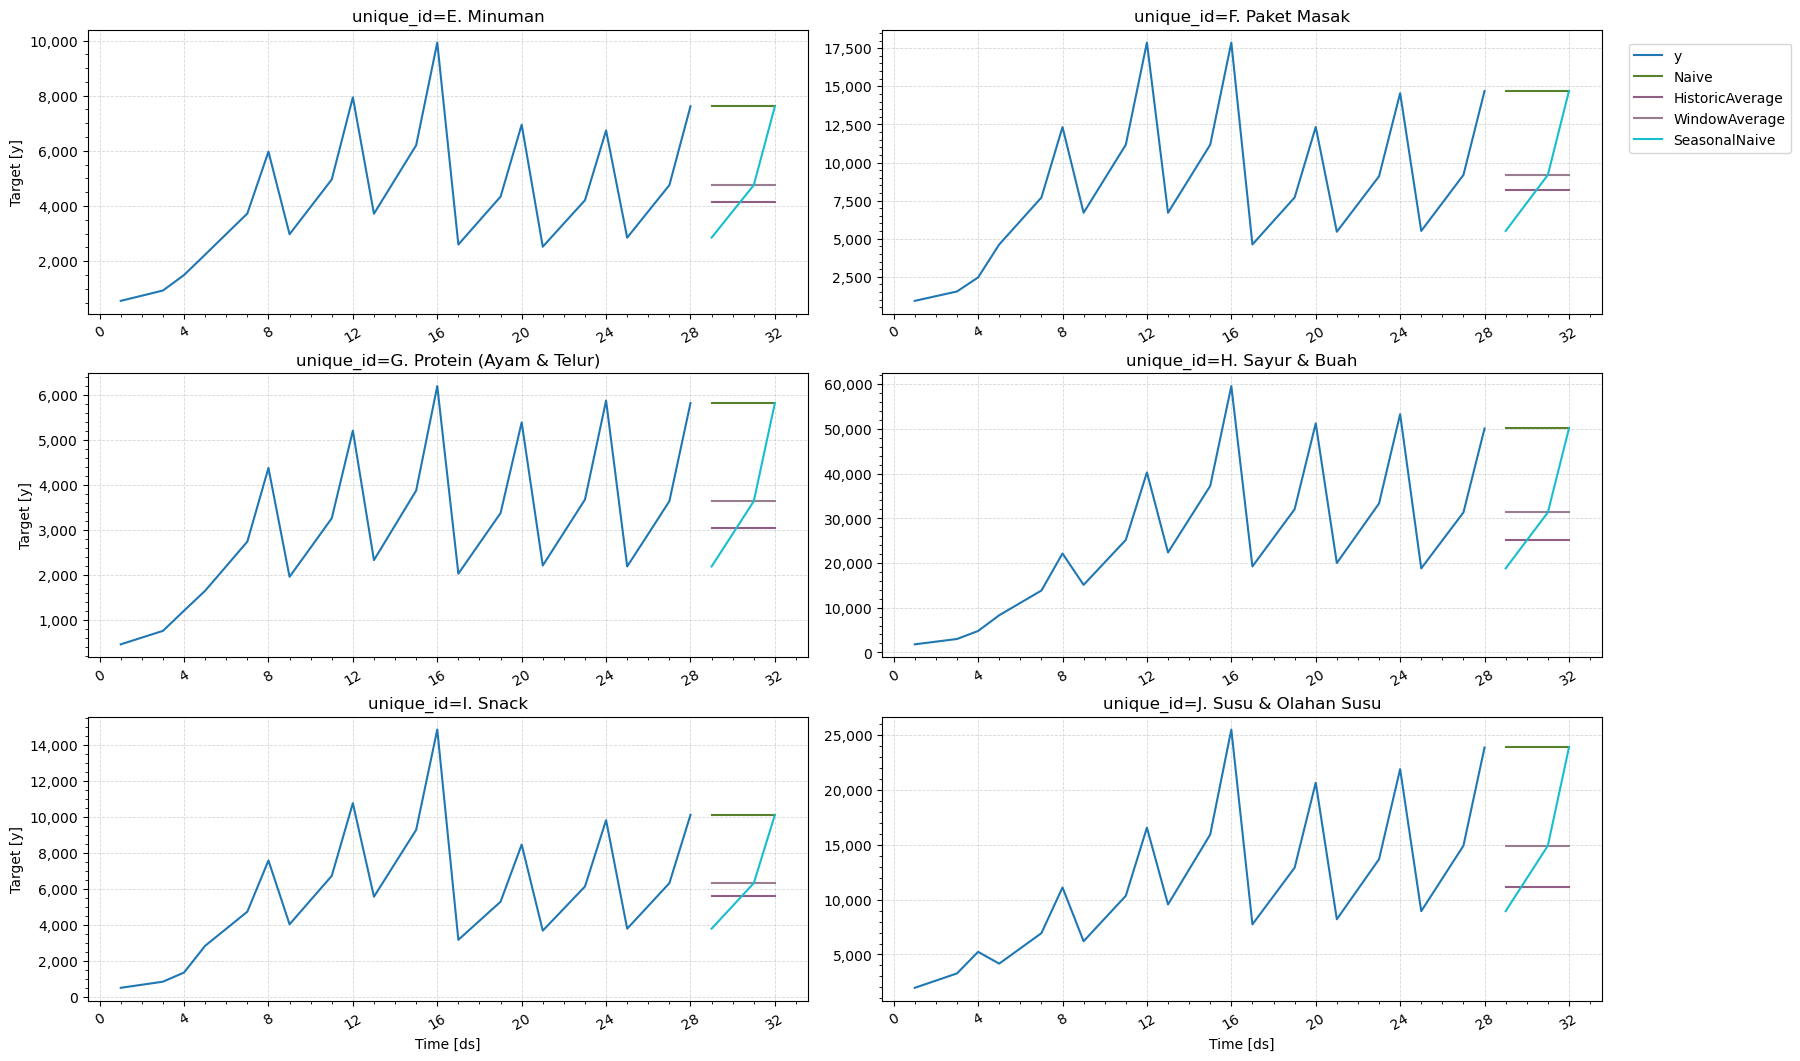

In [343]:
fig = plot_series(df=df_modelovl, forecasts_df=predsovl, ids=ids2)

for ax in fig.axes:
    ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.5)
    ax.minorticks_on()
    ax.set_xticks(ticks=range(0,33,4))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}"))

fig

### Specific per Hub per Category Forecast

In [269]:
horizon = 4

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=4),
    SeasonalNaive(season_length=4)
]

sf = StatsForecast(models=models, freq=1)
sf.fit(df=df_model)
preds = sf.predict(h=horizon)

preds.head() #Simple prediction for benchmarking SARIMA

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,A-A. Bahan & Bumbu Masak,29,3229.0,1458.607143,2018.25,1211.0
1,A-A. Bahan & Bumbu Masak,30,3229.0,1458.607143,2018.25,1615.0
2,A-A. Bahan & Bumbu Masak,31,3229.0,1458.607143,2018.25,2018.0
3,A-A. Bahan & Bumbu Masak,32,3229.0,1458.607143,2018.25,3229.0
4,A-B. Daging Beku,29,3731.0,1529.285714,2331.75,1399.0


## **4. Baseline Models Evaluation**

### Overall Forecast Evaluation

In [346]:
test_ovrl = df_modelovl.groupby(['unique_id']).tail(4)
train_ovrl = df_modelovl.drop(test_ovrl.index).reset_index(drop=True)

sf.fit(df=train_ovrl)
predsovl_eval = sf.predict(h=horizon)
evalovrl_df = pd.merge(test_ovrl, predsovl_eval, 'left', ['ds', 'unique_id'])

evaluation_ovrl = evaluate(
    evalovrl_df,
    metrics=[smape]
)

evaluation_ovrl

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,A. Bahan & Bumbu Masak,smape,0.234774,0.185586,0.147892,0.047573
1,B. Daging Beku,smape,0.213885,0.212998,0.147203,0.095055
2,C. Kebutuhan Pokok,smape,0.348045,0.168767,0.198431,0.105301
3,D. Makanan Beku,smape,0.240647,0.273162,0.148003,0.033784
4,E. Minuman,smape,0.229010,0.147504,0.147757,0.061101
5,F. Paket Masak,smape,0.252623,0.147725,0.147993,0.004958
6,G. Protein (Ayam & Telur),smape,0.259007,0.147016,0.150419,0.004883
7,H. Sayur & Buah,smape,0.282516,0.156005,0.163133,0.030927
8,I. Snack,smape,0.248607,0.147702,0.148052,0.014758
9,J. Susu & Olahan Susu,smape,0.236691,0.176205,0.147931,0.043050


In [347]:
evaluationovrl_avg = evaluation_ovrl.drop('unique_id', axis=1).groupby('metric').mean().reset_index()
evaluationovrl_avg

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,smape,0.254581,0.176267,0.154681,0.044139


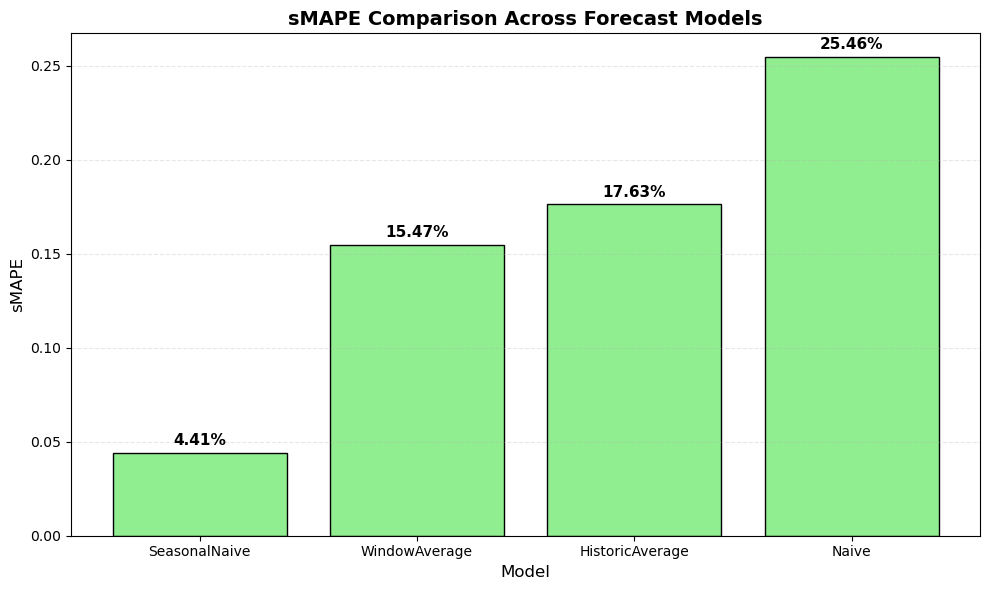

In [349]:
# Remove the 'metric' column for plotting
plot_df = evaluationovrl_avg.drop(columns=['metric'])

# Convert to Series so it's easier to sort
s = plot_df.iloc[0]

# Sort ASCENDING (best = lowest sMAPE)
s_sorted = s.sort_values()

plt.figure(figsize=(10, 6))

bars = plt.bar(s_sorted.index, s_sorted.values, edgecolor='black', color='lightgreen')

# Title & labels
plt.title("sMAPE Comparison Across Forecast Models", fontsize=14, weight='bold')
plt.ylabel("sMAPE", fontsize=12)
plt.xlabel("Model", fontsize=12)

# Clean grid
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add labels above bars
for bar, v in zip(bars, s_sorted.values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        v + (max(s_sorted.values)*0.01),
        f"{v*100:.2f}%",
        ha='center',
        va='bottom',
        fontsize=11,
        weight='bold'
    )

plt.tight_layout()
plt.show()

### Specific Forecast Evaluation

In [ ]:
test = df_model.groupby(['unique_id']).tail(4)
train = df_model.drop(test.index).reset_index(drop=True)

In [278]:
sf.fit(df=train)
preds_eval = sf.predict(h=horizon)
eval_df = pd.merge(test, preds_eval, 'left', ['ds', 'unique_id'])

In [279]:
eval_df.head()

,unique_id,ds,y,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,A-A. Bahan & Bumbu Masak,25,1211.0,2936.0,1365.333333,1835.0,1101.0
1,A-A. Bahan & Bumbu Masak,26,1615.0,2936.0,1365.333333,1835.0,1468.0
2,A-A. Bahan & Bumbu Masak,27,2018.0,2936.0,1365.333333,1835.0,1835.0
3,A-A. Bahan & Bumbu Masak,28,3229.0,2936.0,1365.333333,1835.0,2936.0
4,A-B. Daging Beku,25,1399.0,3083.0,1395.541667,1927.0,1156.0


In [280]:
evaluation = evaluate(
    eval_df,
    metrics=[mae]
)
evaluation.head(11)

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,A-A. Bahan & Bumbu Masak,mae,1064.25,730.083333,605.25,183.25
1,A-B. Daging Beku,mae,1075.25,936.208333,699.75,404.75
2,A-C. Kebutuhan Pokok,mae,336.25,118.562500,143.75,81.25
3,A-D. Makanan Beku,mae,1073.50,931.708333,588.00,128.25
4,A-E. Minuman,mae,483.50,285.500000,285.50,109.75
5,A-F. Paket Masak,mae,884.50,448.000000,448.00,14.75
6,A-G. Protein (Ayam & Telur),mae,448.00,218.500000,222.00,7.00
7,A-H. Sayur & Buah,mae,2761.00,1239.750000,1305.00,251.00
8,A-I. Snack,mae,429.25,223.250000,223.25,21.75
9,A-J. Susu & Olahan Susu,mae,1093.75,712.020833,614.75,169.00


In [281]:
evaluation_avg = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation_avg

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,1176.83,671.909583,614.54,146.44


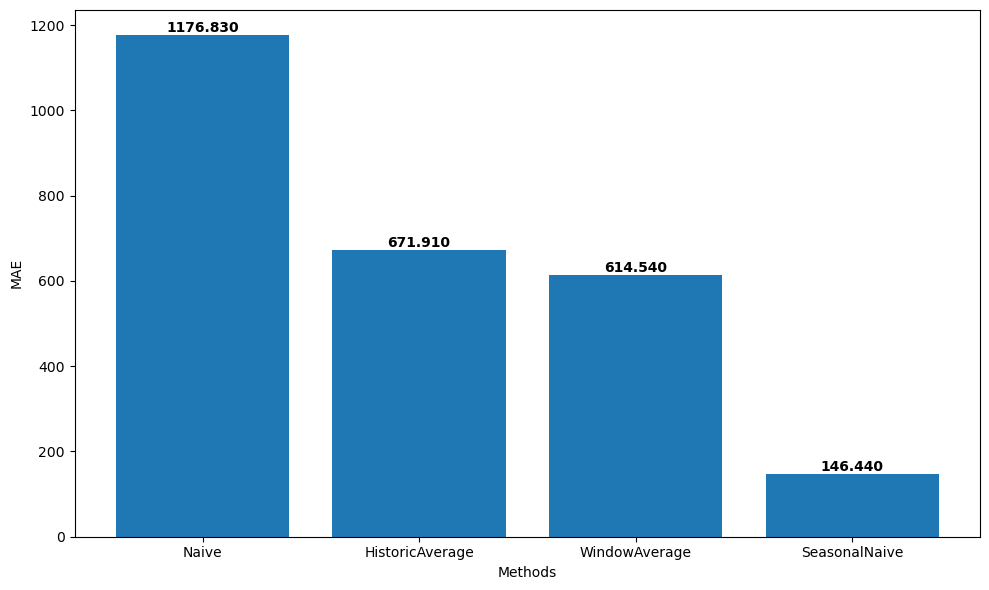

In [282]:
methods = evaluation_avg.columns[1:].tolist()
values = evaluation_avg.iloc[0,1:].tolist()

plt.figure(figsize=(10,6))
bars = plt.bar(methods, values)

for bar, values in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{values:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('MAE')
plt.tight_layout()
plt.show()

## **5. ARIMA/SARIMA Forecast**

In [326]:
from statsforecast.models import AutoARIMA

### Overall Product Forecast

In [350]:
models = [
    AutoARIMA(seasonal=False, alias='ARIMA'),
    AutoARIMA(season_length=4, alias='SARIMA')
]

sf = StatsForecast(models=models, freq=1)
sf.fit(df=df_modelovl)
arima_predsovl = sf.predict(h=horizon)

arima_predsovl.tail()

,unique_id,ds,ARIMA,SARIMA
35,I. Snack,32,7471.315399,10394.878037
36,J. Susu & Olahan Susu,29,19388.663654,10892.025268
37,J. Susu & Olahan Susu,30,20167.718418,13861.282867
38,J. Susu & Olahan Susu,31,20946.773182,16834.721082
39,J. Susu & Olahan Susu,32,21725.827946,25776.560193


### Specific Forecast

In [327]:
models = [
    AutoARIMA(seasonal=False, alias='ARIMA'),
    AutoARIMA(season_length=4, alias='SARIMA')
]

sf = StatsForecast(models=models, freq=1)
sf.fit(df=df_model)
arima_preds = sf.predict(h=horizon)

arima_preds.tail()

,unique_id,ds,ARIMA,SARIMA
195,E-I. Snack,32,1757.930031,2445.945432
196,E-J. Susu & Olahan Susu,29,5067.782799,2910.157524
197,E-J. Susu & Olahan Susu,30,5212.001812,3703.393271
198,E-J. Susu & Olahan Susu,31,5356.220825,4498.322442
199,E-J. Susu & Olahan Susu,32,5500.439838,6887.183216


## **6. ARIMA/SARIMA Evaluation**

### MAE Evaluation

In [290]:
sf = StatsForecast(models=models, freq=1)
sf.fit(df=train)
arima_preds_eval = sf.predict(h=horizon)

arima_eval_df = pd.merge(arima_preds_eval, eval_df, 'inner', ['ds', 'unique_id'])
arima_eval = evaluate(arima_eval_df, metrics=[mae])

arima_eval.head()

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,A-A. Bahan & Bumbu Masak,mae,861.118433,116.559770,1064.25,730.083333,605.25,183.25
1,A-B. Daging Beku,mae,835.564238,383.542346,1075.25,936.208333,699.75,404.75
2,A-C. Kebutuhan Pokok,mae,162.883629,150.646453,336.25,118.562500,143.75,81.25
3,A-D. Makanan Beku,mae,666.741831,158.937685,1073.50,931.708333,588.00,128.25
4,A-E. Minuman,mae,315.997707,150.978915,483.50,285.500000,285.50,109.75


In [ ]:
arima_preds_eval.head()

,unique_id,ds,ARIMA,SARIMA
0,A-A. Bahan & Bumbu Masak,25,2529.736865,1282.672917
1,A-A. Bahan & Bumbu Masak,26,2622.889149,1581.419411
2,A-A. Bahan & Bumbu Masak,27,2716.041432,1905.808369
3,A-A. Bahan & Bumbu Masak,28,2809.193715,2980.206058
4,A-B. Daging Beku,25,2603.628475,1177.207654


In [ ]:
eval_df.head()

In [ ]:
arima_eval_avg = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
arima_eval_avg

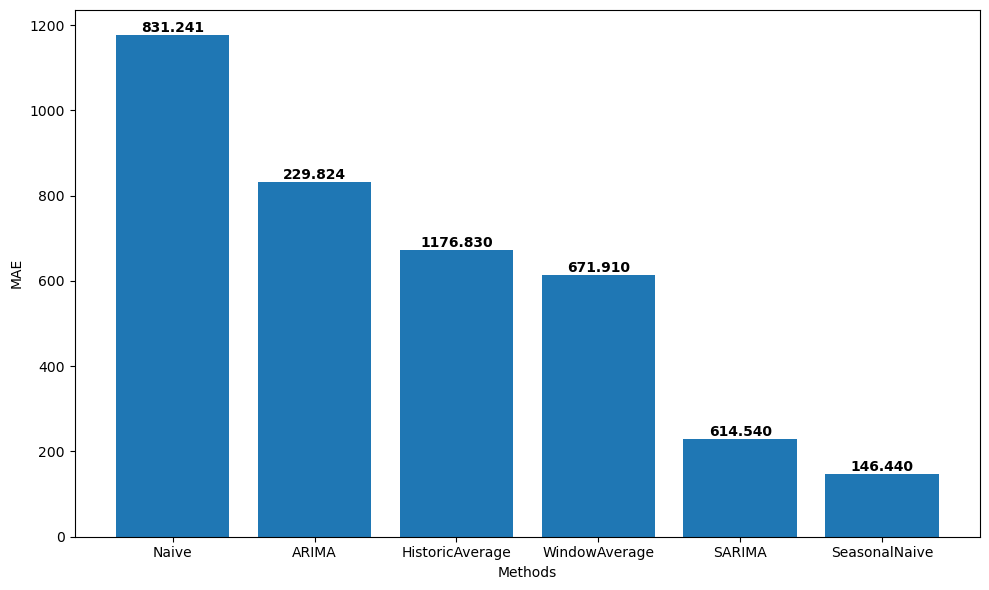

In [330]:
methods = arima_eval_avg.columns[1:].tolist()
values = arima_eval_avg.iloc[0,1:].tolist()

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10,6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, values in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{values:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('MAE')
plt.tight_layout()
plt.show()

### sMAPE Evaluation

In [352]:
sf.fit(df=train_ovrl)
arima_predsovl_eval = sf.predict(h=horizon)

arima_eval_df = pd.merge(arima_predsovl_eval, evalovrl_df, 'inner', ['ds', 'unique_id'])
arima_evalovl = evaluate(arima_eval_df, metrics=[smape])

arima_evalovl.head()

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,A. Bahan & Bumbu Masak,smape,0.190503,0.027014,0.234774,0.185586,0.147892,0.047573
1,B. Daging Beku,smape,0.167433,0.088882,0.213885,0.212998,0.147203,0.095055
2,C. Kebutuhan Pokok,smape,0.217903,0.191375,0.348045,0.168767,0.198431,0.105301
3,D. Makanan Beku,smape,0.167501,0.050655,0.240647,0.273162,0.148003,0.033784
4,E. Minuman,smape,0.163238,0.089510,0.229010,0.147504,0.147757,0.061101


In [353]:
arima_evalovrl_avg = arima_evalovl.drop('unique_id', axis=1).groupby('metric').mean().reset_index()
arima_evalovrl_avg

,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,smape,0.188211,0.077455,0.254581,0.176267,0.154681,0.044139


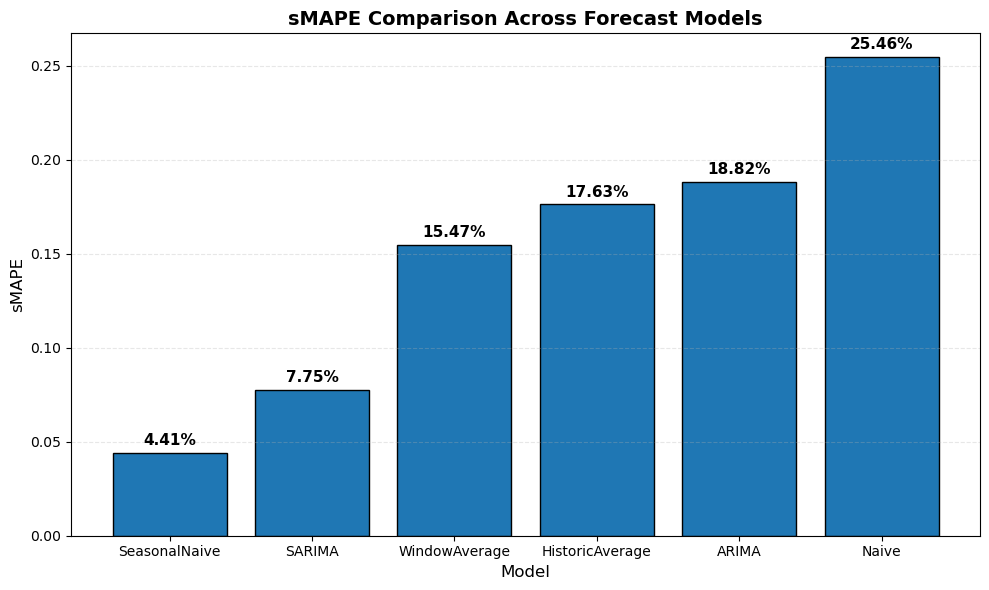

In [354]:
# Remove the 'metric' column for plotting
plot_df = arima_evalovrl_avg.drop(columns=['metric'])

# Convert to Series so it's easier to sort
s = plot_df.iloc[0]

# Sort ASCENDING (best = lowest sMAPE)
s_sorted = s.sort_values()

plt.figure(figsize=(10, 6))

bars = plt.bar(s_sorted.index, s_sorted.values, edgecolor='black')

# Title & labels
plt.title("sMAPE Comparison Across Forecast Models", fontsize=14, weight='bold')
plt.ylabel("sMAPE", fontsize=12)
plt.xlabel("Model", fontsize=12)

# Clean grid
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add labels above bars
for bar, v in zip(bars, s_sorted.values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        v + (max(s_sorted.values)*0.01),
        f"{v*100:.2f}%",
        ha='center',
        va='bottom',
        fontsize=11,
        weight='bold'
    )

plt.tight_layout()
plt.show()

In [ ]:
arima_eval_smape = evaluate(arima_eval_df, metrics=[smape])
arima_eval_avg_smape = arima_eval_smape.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
arima_eval_avg_smape

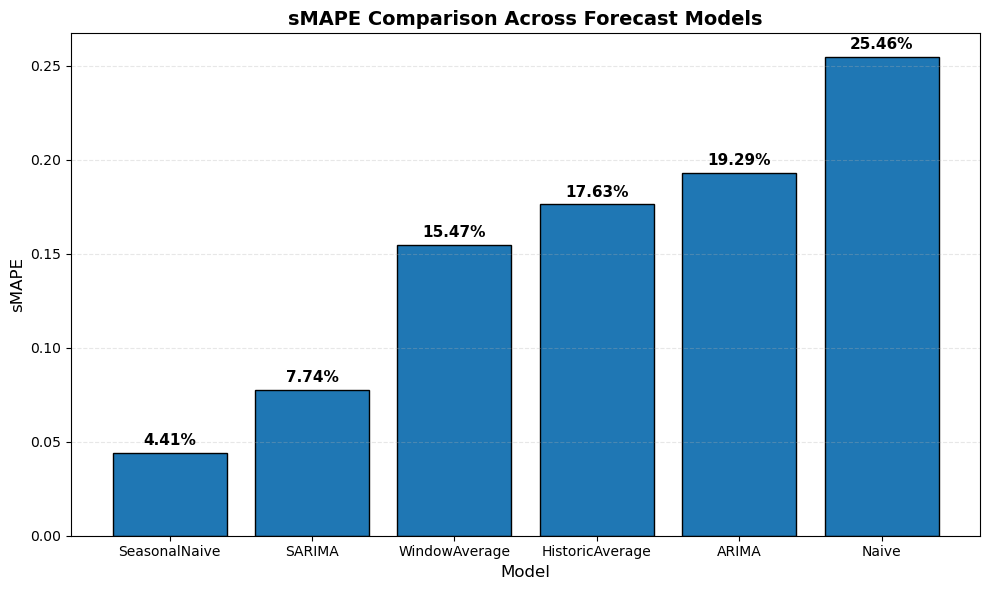

In [332]:
# Remove the 'metric' column for plotting
plot_df = arima_eval_avg_smape.drop(columns=['metric'])

# Convert to Series so it's easier to sort
s = plot_df.iloc[0]

# Sort ASCENDING (best = lowest sMAPE)
s_sorted = s.sort_values()

plt.figure(figsize=(10, 6))

bars = plt.bar(s_sorted.index, s_sorted.values, edgecolor='black')

# Title & labels
plt.title("sMAPE Comparison Across Forecast Models", fontsize=14, weight='bold')
plt.ylabel("sMAPE", fontsize=12)
plt.xlabel("Model", fontsize=12)

# Clean grid
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add labels above bars
for bar, v in zip(bars, s_sorted.values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        v + (max(s_sorted.values)*0.01),
        f"{v*100:.2f}%",
        ha='center',
        va='bottom',
        fontsize=11,
        weight='bold'
    )

plt.tight_layout()
plt.show()

## **Final Prediction Processing**

In [ ]:
preds

In [ ]:
hub_a_preds = preds[preds['unique_id'].str.startswith('A-')].drop(['HistoricAverage', 'Naive', 'WindowAverage'], axis=1)
hub_a_preds.head()

In [ ]:
hub_b_preds = preds[preds['unique_id'].str.startswith('B-')].drop(['HistoricAverage', 'Naive', 'WindowAverage'], axis=1)
hub_b_preds.head()

In [ ]:
hub_c_preds = preds[preds['unique_id'].str.startswith('C-')].drop(['HistoricAverage', 'Naive', 'WindowAverage'], axis=1)
hub_c_preds.head()

In [ ]:
hub_d_preds = preds[preds['unique_id'].str.startswith('D-')].drop(['HistoricAverage', 'Naive', 'WindowAverage'], axis=1)
hub_d_preds.head()

In [ ]:
hub_e_preds = preds[preds['unique_id'].str.startswith('E-')].drop(['HistoricAverage', 'Naive', 'WindowAverage'], axis=1)
hub_e_preds.head()

In [ ]:
hub_a_preds.to_csv(r'C:\Users\ammar\Documents\Data Analytics\Projects\Qcommerce Forecasting\hub_a_preds.csv')
hub_b_preds.to_csv(r'C:\Users\ammar\Documents\Data Analytics\Projects\Qcommerce Forecasting\hub_b_preds.csv')
hub_c_preds.to_csv(r'C:\Users\ammar\Documents\Data Analytics\Projects\Qcommerce Forecasting\hub_c_preds.csv')
hub_d_preds.to_csv(r'C:\Users\ammar\Documents\Data Analytics\Projects\Qcommerce Forecasting\hub_d_preds.csv')
hub_e_preds.to_csv(r'C:\Users\ammar\Documents\Data Analytics\Projects\Qcommerce Forecasting\hub_e_preds.csv')